<a href="https://colab.research.google.com/github/Catalinafernandez11/laboratorio_datos/blob/main/tp1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Trabajo práctico \# 1
Integrantes: Carlos Bolívar, Catalina Fernandez

## Importación de librerías

In [ ]:
!pip install formulaic

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import seaborn.objects as so

from formulaic import Formula

# Herramientas de modelos lineales
from sklearn import linear_model

# Medidas de desempeño
from sklearn.metrics import mean_squared_error, r2_score, root_mean_squared_error
import datetime

## Procesamiento de datos

In [ ]:
datos = pd.read_csv('full_data.csv')

In [ ]:
datos.head()

,station_id,num_bikes_available,num_bikes_disabled,num_docks_available,num_docks_disabled,last_reported,is_charging_station,status,is_installed,is_renting,is_returning,traffic,num_bikes_available_types.mechanical,num_bikes_available_types.ebike,Date,hora,dia
0,420,3,1,8,0,1.745880e+09,False,IN_SERVICE,1,1,1,NaN,3,0,2025-04-28,23:28:05,Monday
1,464,11,2,7,0,1.745894e+09,False,IN_SERVICE,1,1,1,NaN,11,0,2025-04-28,23:28:05,Monday
2,420,5,1,6,1,1.745897e+09,False,IN_SERVICE,1,1,1,NaN,5,0,2025-04-29,00:32:59,Tuesday
3,464,11,2,7,0,1.745898e+09,False,IN_SERVICE,1,1,1,NaN,11,0,2025-04-29,00:32:59,Tuesday
4,420,5,1,6,1,1.745900e+09,False,IN_SERVICE,1,1,1,NaN,5,0,2025-04-29,01:13:46,Tuesday


In [ ]:
# Verifiquemos que las estaciones disponibles sean únicamente dos
datos.station_id.unique()

array([420, 464])

In [ ]:
# Nos quedamos con el subconjunto relevante de columnas
columnas_relevantes = ["station_id", "num_bikes_available", "num_bikes_disabled",
                                  "num_docks_available", "num_docks_disabled",
                                  "Date", "hora", "dia", 'status']
datos_limpios = datos[columnas_relevantes]

In [ ]:
columnas_renombradas = {
    "station_id": "estacion",
    "num_bikes_available": "bicis_disponibles",
    "num_bikes_disabled": "bicis_rotas",
    "num_docks_available": "puertos_disponibles",
    "num_docks_disabled": "puertos_rotos",
    "Date": "fecha",
    "hora": "horario",
    "dia": "dia_semana",
    "status":"estado"
}

dias_semana = {
        "Monday": "Lunes","Tuesday": "Martes","Wednesday": "Miercoles","Thursday": "Jueves",
        "Friday": "Viernes","Saturday": "Sabado", "Sunday": "Domingo" }

datos_limpios = datos_limpios.rename(columns = columnas_renombradas)
datos_limpios['dia_semana'] = datos_limpios['dia_semana'].map(dias_semana)


In [ ]:
datos_limpios.info()
# Tenemos datos numericos (incluida estacion, que seria el identificador para esa estacion)
# Y tambien strings, para fecha, horario y dia de semana

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12528 entries, 0 to 12527
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   estacion             12528 non-null  int64 
 1   bicis_disponibles    12528 non-null  int64 
 2   bicis_rotas          12528 non-null  int64 
 3   puertos_disponibles  12528 non-null  int64 
 4   puertos_rotos        12528 non-null  int64 
 5   fecha                12528 non-null  object
 6   horario              12528 non-null  object
 7   dia_semana           12528 non-null  object
 8   estado               12528 non-null  object
dtypes: int64(5), object(4)
memory usage: 881.0+ KB


In [ ]:
datos_limpios.isna().any()
# No hay valores NaN

,0
estacion,False
bicis_disponibles,False
bicis_rotas,False
puertos_disponibles,False
puertos_rotos,False
fecha,False
horario,False
dia_semana,False
estado,False


In [ ]:
# Aunque optaremos por transformar las variables de fecha y hora a datetime,
# probemos extraer el mes y la hora, respectivamente aprovechando que podemos usar
# el slicing de strings
print('Ejemplos de meses extraidos de fecha: ', datos_limpios['fecha'].str[5:7].head().values)
print('Ejemplos de horas extraidas de horario: ', datos_limpios['horario'].str[0:2].head().values)


Ejemplos de meses extraidos de fecha:  ['04' '04' '04' '04' '04']
Ejemplos de horas extraidas de horario:  ['23' '23' '00' '00' '01']


In [ ]:
#Notemos que esos valores extraidos de fecha y hora son strings,
# si quisieramos convertirlos a uno numerico podriamos optar por:
pd.to_numeric(datos_limpios['fecha'].str[5:7].head())

,fecha
0,4
1,4
2,4
3,4
4,4


In [ ]:
#Usemos el formato datetime
datos_limpios["fecha"] = pd.to_datetime(datos_limpios["fecha"])
datos_limpios["horario"] = pd.to_datetime(datos_limpios["horario"]).dt.time

/tmp/ipython-input-3359621119.py:3: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  datos_limpios["horario"] = pd.to_datetime(datos_limpios["horario"]).dt.time


In [ ]:
def determinar_estacion_anio(fecha: datetime.datetime):
  anio = fecha.year
  verano_inicio = datetime.datetime(anio, 12, 21)
  otono_inicio = datetime.datetime(anio, 3, 21)
  invierno_inicio = datetime.datetime(anio, 6, 21)
  primavera_inicio = datetime.datetime(anio, 9, 23)

  if fecha >= verano_inicio or fecha < otono_inicio:
    estacion = 'Verano'
  elif otono_inicio <= fecha < invierno_inicio:
    estacion = 'Otoño'
  elif invierno_inicio <= fecha < primavera_inicio:
    estacion = 'Invierno'
  else:
    estacion = 'Primavera'

  return estacion




In [ ]:
datos_limpios['estacion_anio'] = datos_limpios['fecha'].apply(determinar_estacion_anio)

In [ ]:
# Efectuemos la creación de columnas de dia, mes, anio y hora
# notemos que va a ser util a la hora de agrupar por fecha y hora
datos_limpios['dia'] = datos_limpios['fecha'].apply(lambda fecha: fecha.day)
datos_limpios['mes'] = datos_limpios['fecha'].apply(lambda fecha: fecha.month)
datos_limpios['anio'] = datos_limpios['fecha'].apply(lambda fecha: fecha.year)
datos_limpios['hora'] = datos_limpios['horario'].apply(lambda horario: horario.hour)




In [ ]:
#Sin embargo, hay datos faltantes! No hay registros en todo Marzo
# Ejercicio, para cada dia. Que hora falta
print('meses disponibles: ', datos_limpios.mes.unique())
print('dias disponbiles: ', datos_limpios.dia.unique())

meses disponibles:  [ 4  5  6  7  8  9 10 11 12  1  2]
dias disponbiles:  [28 29 30  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21
 22 23 24 25 26 27 31]


## Análisis descriptivo

In [ ]:
datos_agrupados = datos_limpios.groupby(['fecha', 'hora', 'dia_semana'])[['bicis_disponibles', 'bicis_rotas', 'puertos_disponibles']].sum().reset_index()

#Agregamos las columnas de anio, mes, dia a partir de fecha
datos_agrupados['dia'] = datos_agrupados['fecha'].apply(lambda fecha: fecha.day)
datos_agrupados['mes'] = datos_agrupados['fecha'].apply(lambda fecha: fecha.month)
datos_agrupados['anio'] = datos_agrupados['fecha'].apply(lambda fecha: fecha.year)
datos_agrupados['estacion_anio'] = datos_agrupados['fecha'].apply(determinar_estacion_anio)


In [ ]:
datos_agrupados.head()

,fecha,hora,dia_semana,bicis_disponibles,bicis_rotas,puertos_disponibles,dia,mes,anio,estacion_anio
0,2025-04-28,23,Lunes,14,3,15,28,4,2025,Otoño
1,2025-04-29,0,Martes,16,3,13,29,4,2025,Otoño
2,2025-04-29,1,Martes,16,3,13,29,4,2025,Otoño
3,2025-04-29,2,Martes,16,3,13,29,4,2025,Otoño
4,2025-04-29,3,Martes,16,3,13,29,4,2025,Otoño


<Axes: >

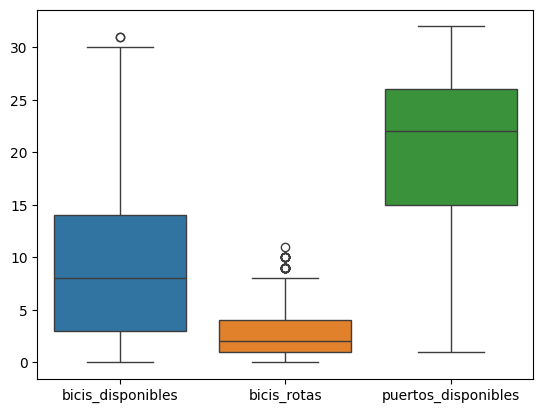

In [ ]:
sns.boxplot(datos_agrupados[['bicis_disponibles', 'bicis_rotas', 'puertos_disponibles']])

In [ ]:
# Agrupando por hora y tomando la mediana de bicis disponibles tenemos:
agrupacion_hora = datos_limpios.groupby(['hora'])[['bicis_disponibles', 'bicis_rotas', 'puertos_disponibles']].median()

In [ ]:
agrupacion_mes = datos_limpios.groupby(['mes'])[['bicis_disponibles', 'bicis_rotas', 'puertos_disponibles']].median()
agrupacion_mes

,bicis_disponibles,bicis_rotas,puertos_disponibles
mes,,,
1,4.0,1.0,10.0
2,2.0,1.5,11.0
4,6.0,3.0,6.0
5,3.0,1.0,9.0
6,6.0,0.0,9.0
7,9.0,0.0,6.0
8,4.0,1.0,10.0
9,1.0,2.0,12.0
10,1.0,2.0,11.0


### Analisis de disponibilidad de bicis en distintas estaciones

Primero, es interesante notar que la disponibilidad de bicis es inversamente proporcional a la cantidad de puertos disponibles (es logico pensar que un puerto deja de estar disponible si hay una bici ocupandolo).

Ahora bien, es claro que hay mas bicis disponibles en Otono e Invierno, es decir, la gente las usa menos. Esto puede deberse a la temperatura: es probable que los estudiantes eviten manejar una bici cuando hace frio.

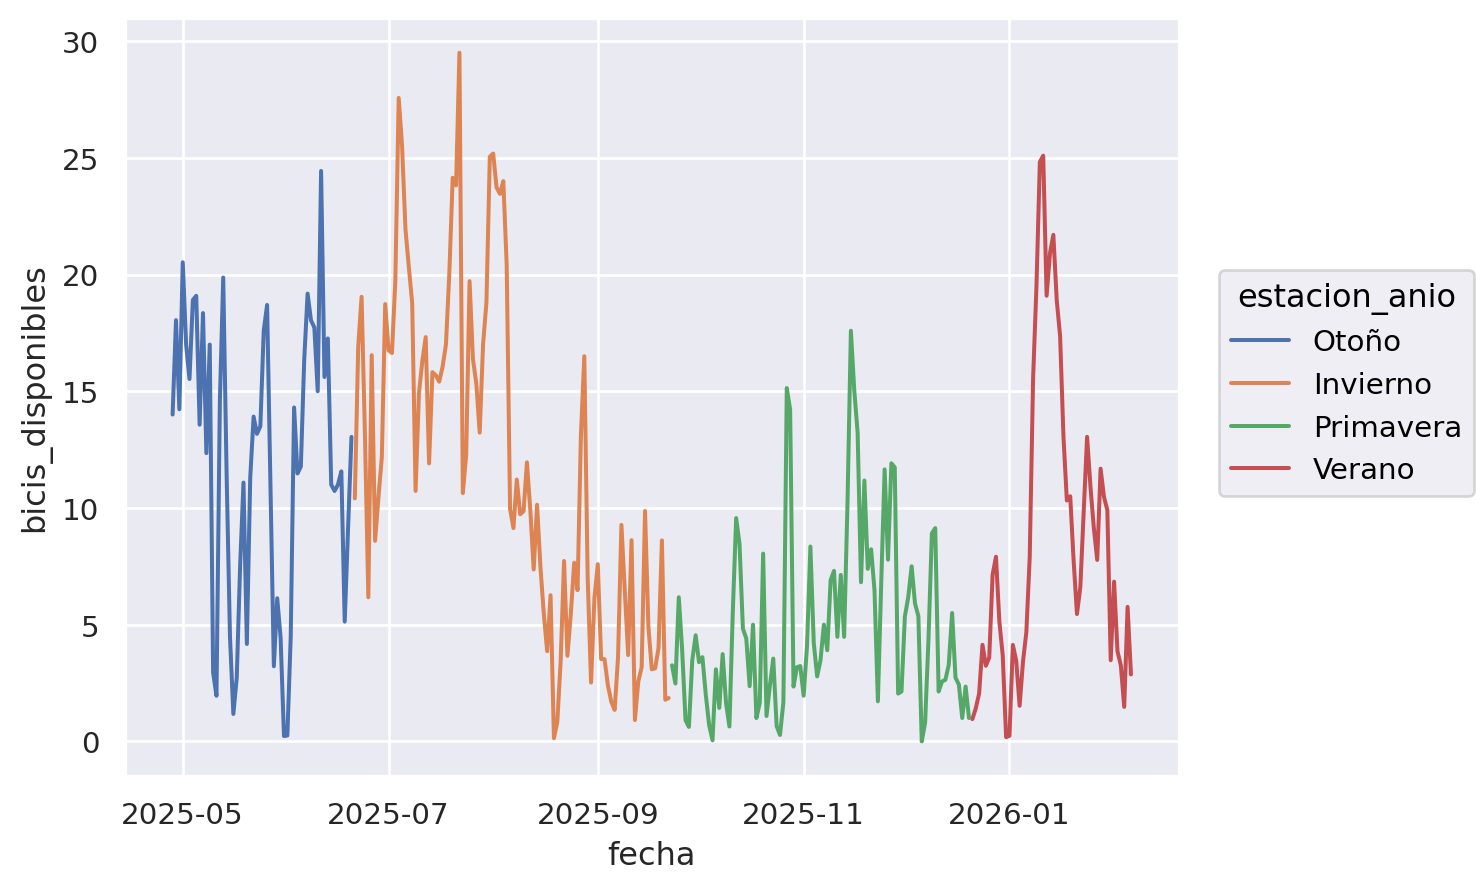

In [ ]:
#Como tenemos varios datos para cada fecha, agregamos la cantidad de bicis disponibles por fecha usando
# el promedio aritmetico
(
    so.Plot(data=datos_agrupados, x='fecha', y='bicis_disponibles', color='estacion_anio')
    .add(so.Line(), so.Agg(func='mean'))
)

#Aunque este gráfico nos da una idea de cómo evoluciona la cantidad de bicis disponibles,
# no es del todo claro qué estación tiene la mayor cantidad de bicis disponibles, en promedio

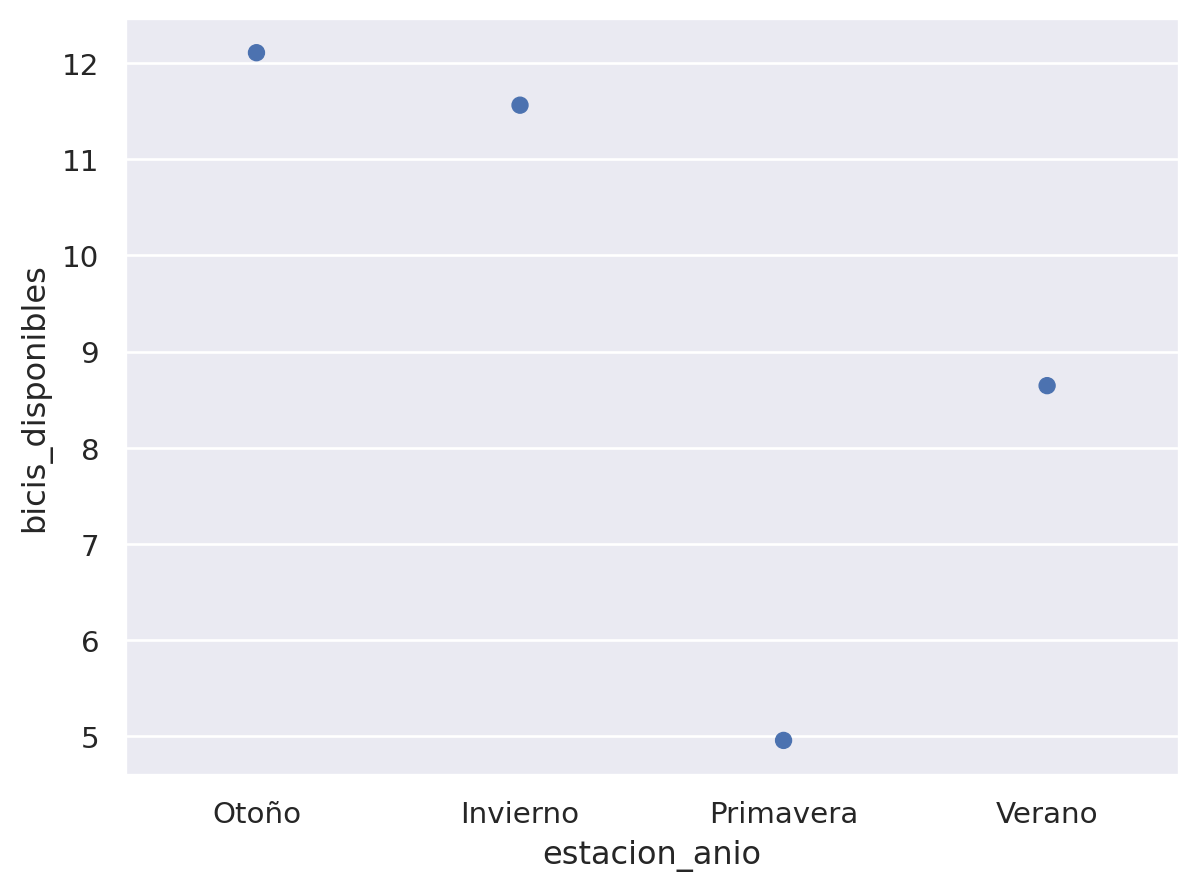

In [ ]:
(
    so.Plot(data=datos_agrupados, x='estacion_anio', y='bicis_disponibles')
    .add(so.Dot(), so.Agg(func='mean'))
)
#Aquí se puede apreciar mejor que, por lo general, en Otoño hay más bicis disponibles

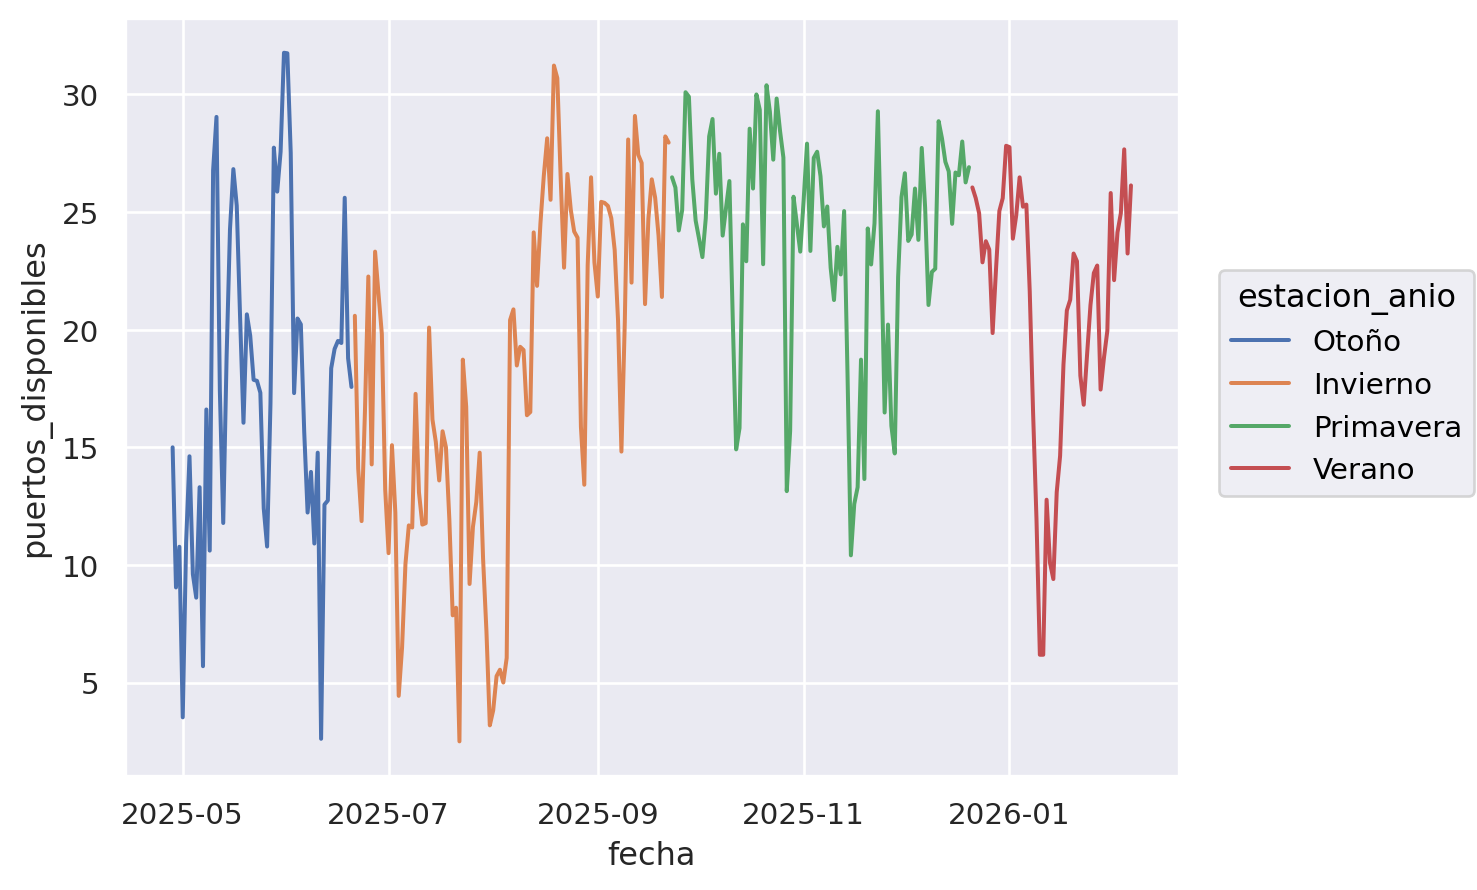

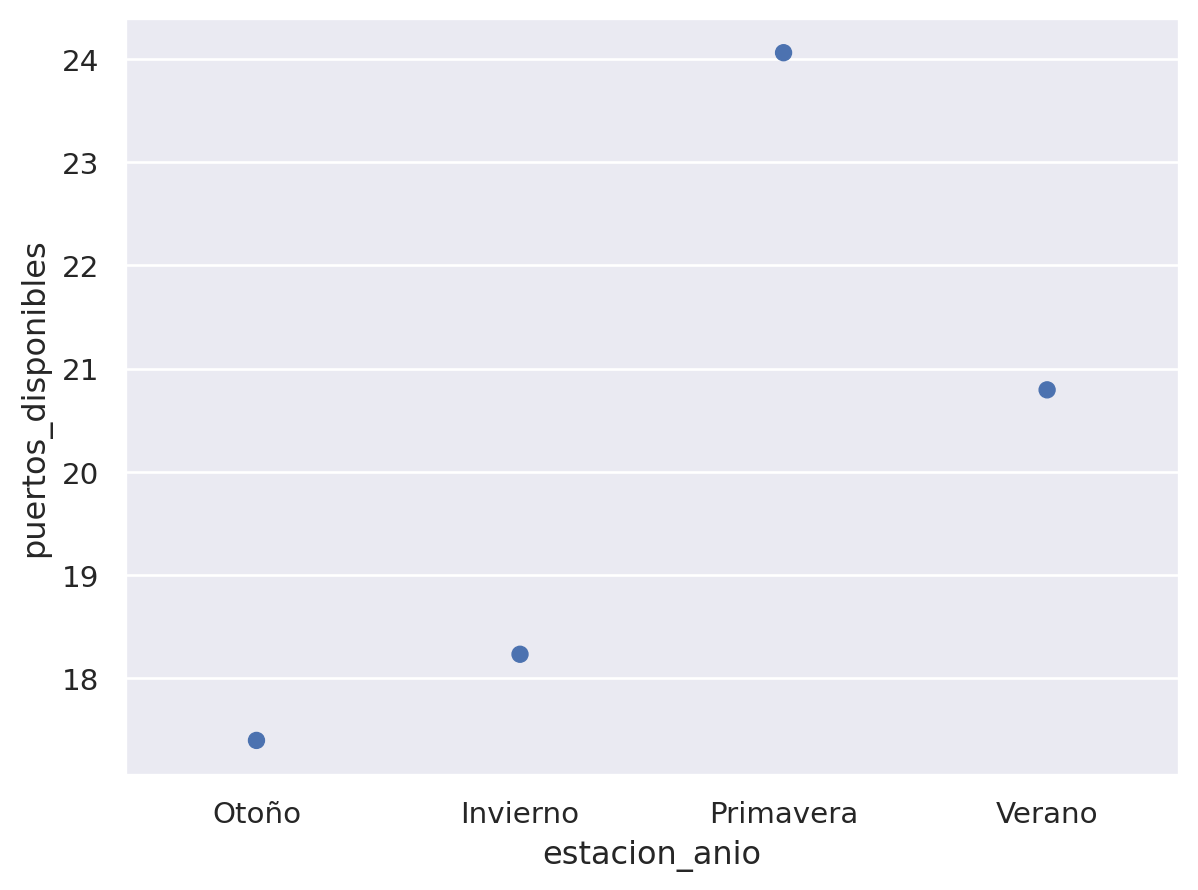

In [ ]:
#¿Y puertos?
display(
    so.Plot(data=datos_agrupados, x='fecha', y='puertos_disponibles', color='estacion_anio')
    .add(so.Line(), so.Agg(func='mean'))
)

display(
    (
    so.Plot(data=datos_agrupados, x='estacion_anio', y='puertos_disponibles')
    .add(so.Dot(), so.Agg(func='mean'))
)
)




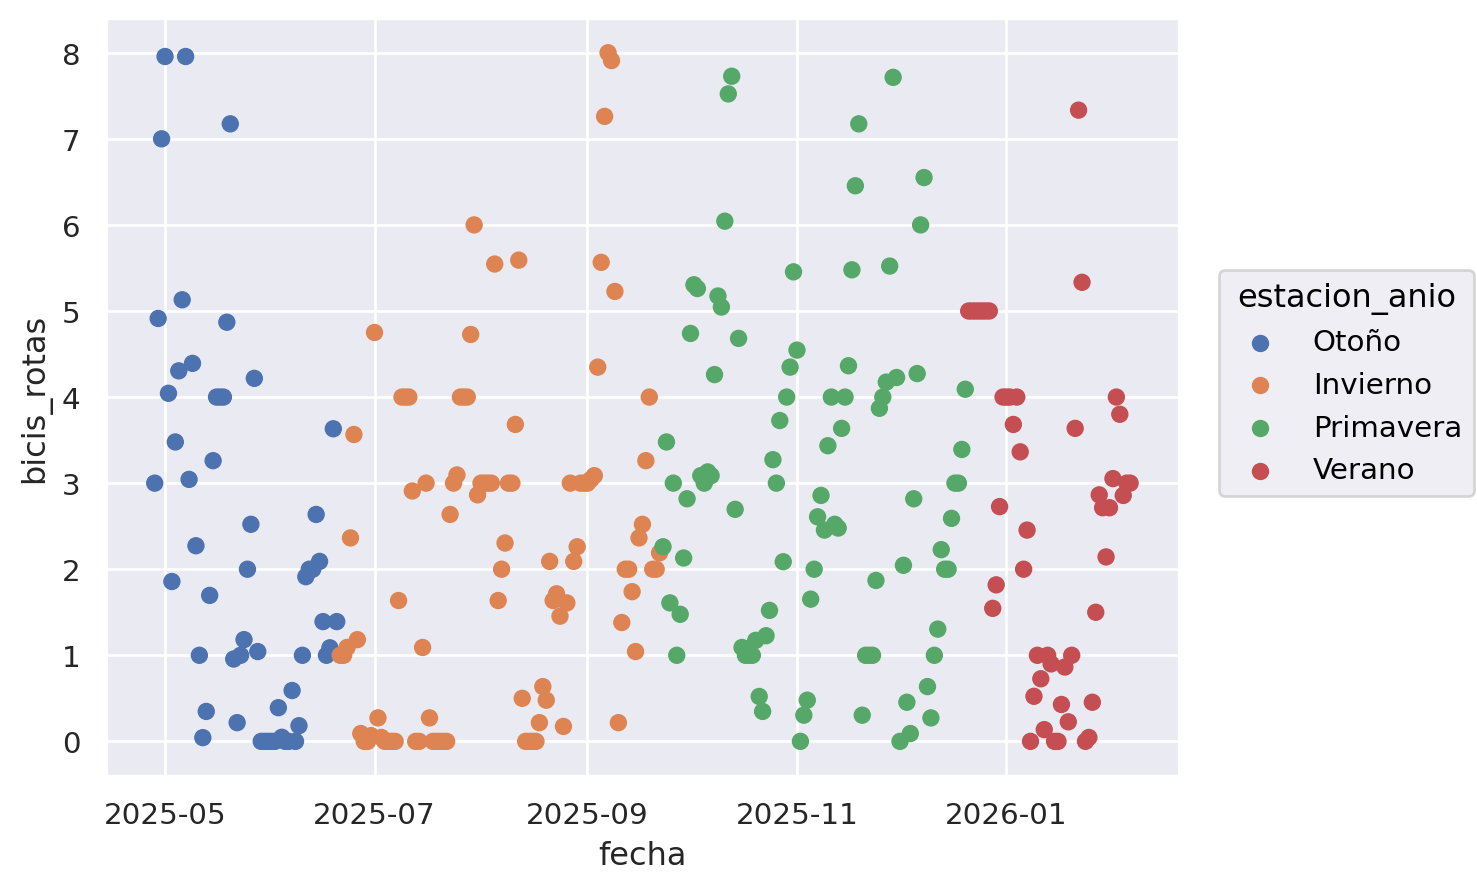

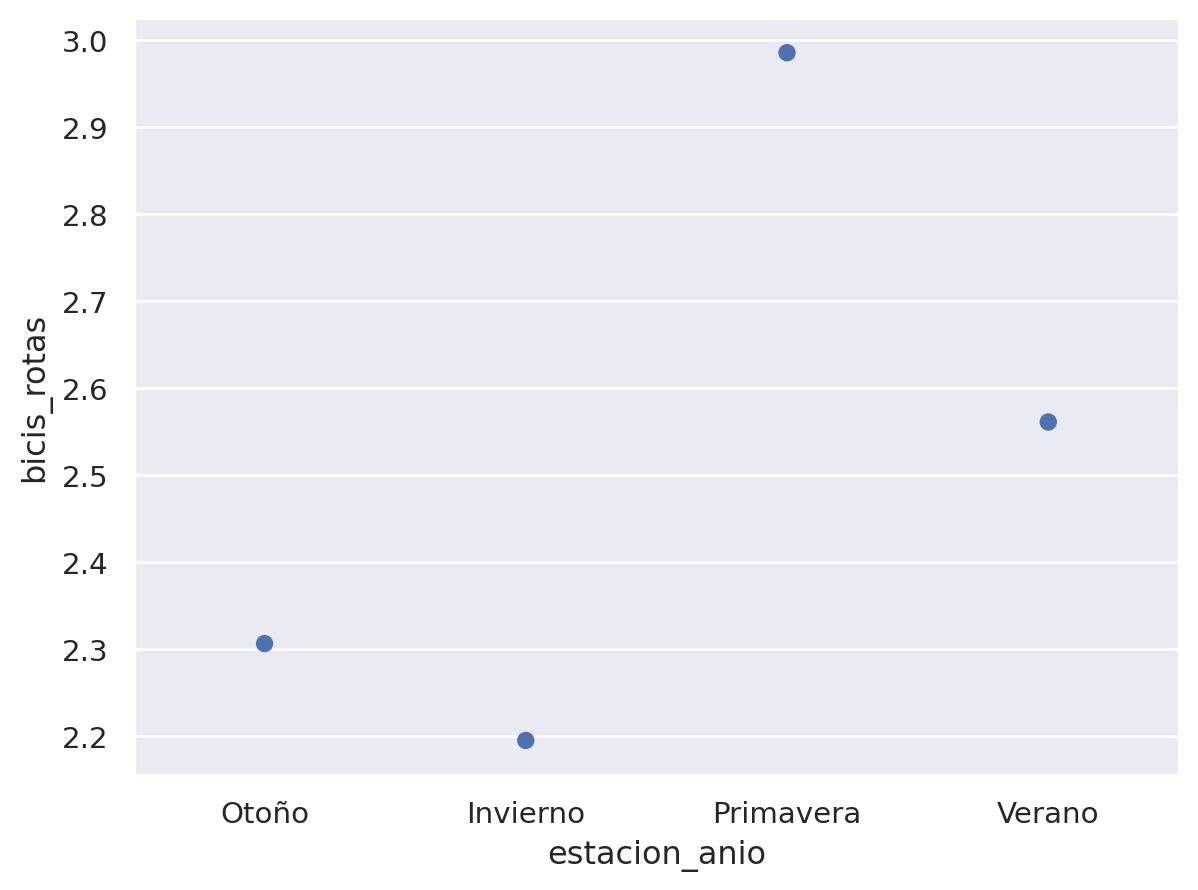

In [ ]:
# A desarrollar:
display(
    so.Plot(data=datos_agrupados, x='fecha', y='bicis_rotas', color='estacion_anio')
    .add(so.Dot(), so.Agg(func='mean'))
)

display(
    (
    so.Plot(data=datos_agrupados, x='estacion_anio', y='bicis_rotas')
    .add(so.Dot(), so.Agg(func='mean'))
)
)

### Disponibilidad de bicicletas y puertos



*   Se puede apreciar visualmente que, en los dias de semana, hay un crecimiento pronunciado de en la disponibilidad de bicis a las 8:00, es decir, se atracan bicis en los puertos disponibles (estudiantes que llegan a la universidad en estas bicis); este horario que coincide con el comienzo de las actividades en la universidad. En ese sentido, es natural que que ese pico no se manifieste con la misma intensidad los dias Sabado y Domingo
*   A partir de las 12 empieza un descenso en la cantidad de bicis disponibles (algunos estudiantes que fueron la universidad en la mañana empiezan a irse)

* A las 21 hay un descenso marcado que puede coincidir con la hora en la que una parte importante de la comunidad educativa se va de la universidad

* Hay un aumento importante, en promedio, a las 22 y luego un descenso que a priori es dificil de explicar



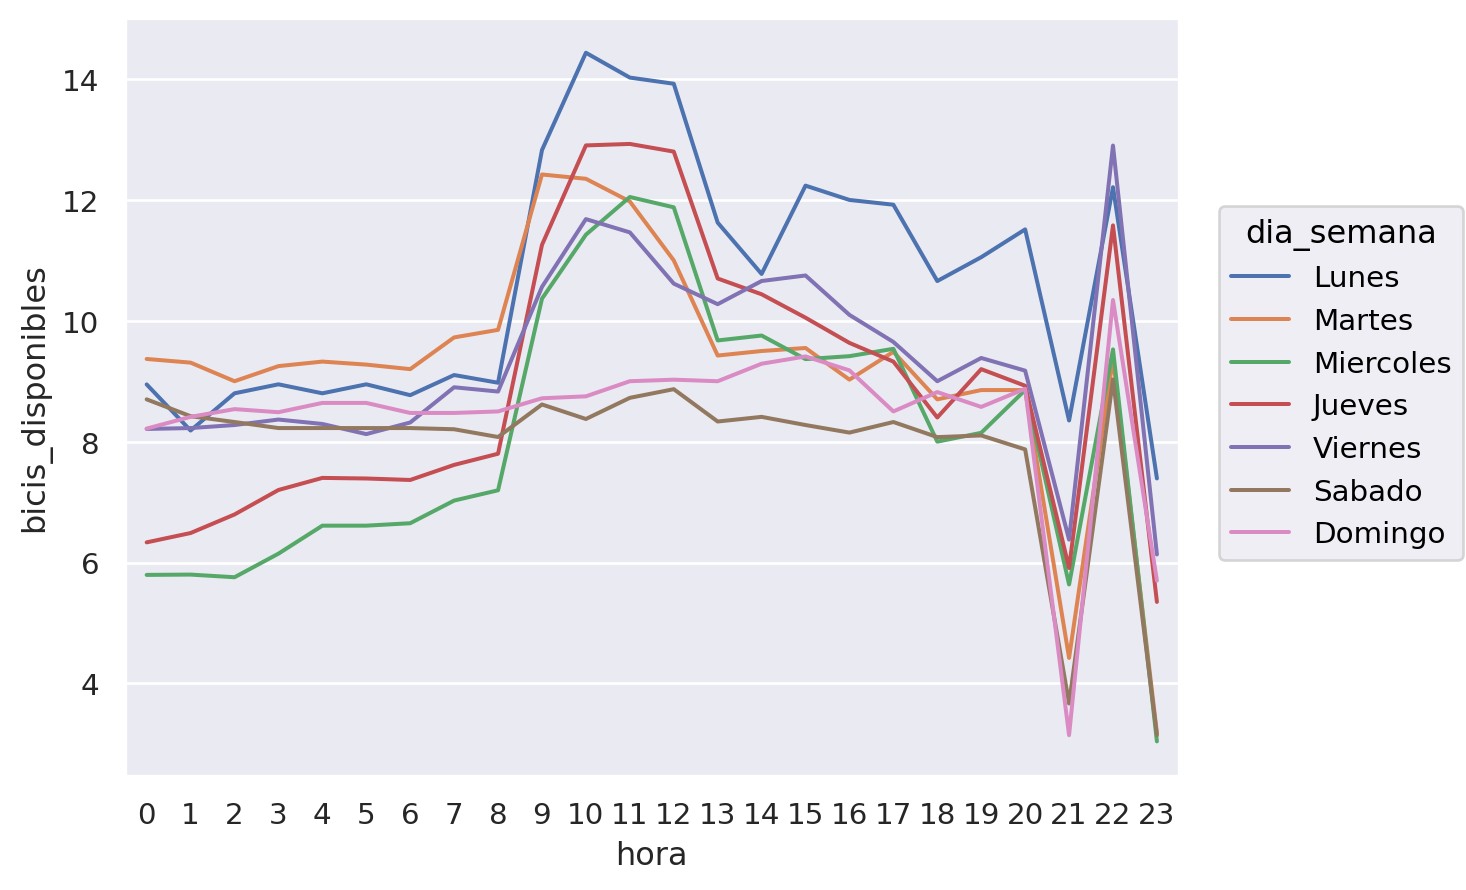

In [ ]:
(
    so.Plot(data=datos_agrupados, x='hora', y='bicis_disponibles', color='dia_semana')
    .add(so.Line(), so.Agg(func='mean'))
    .scale(x=so.Nominal())
)

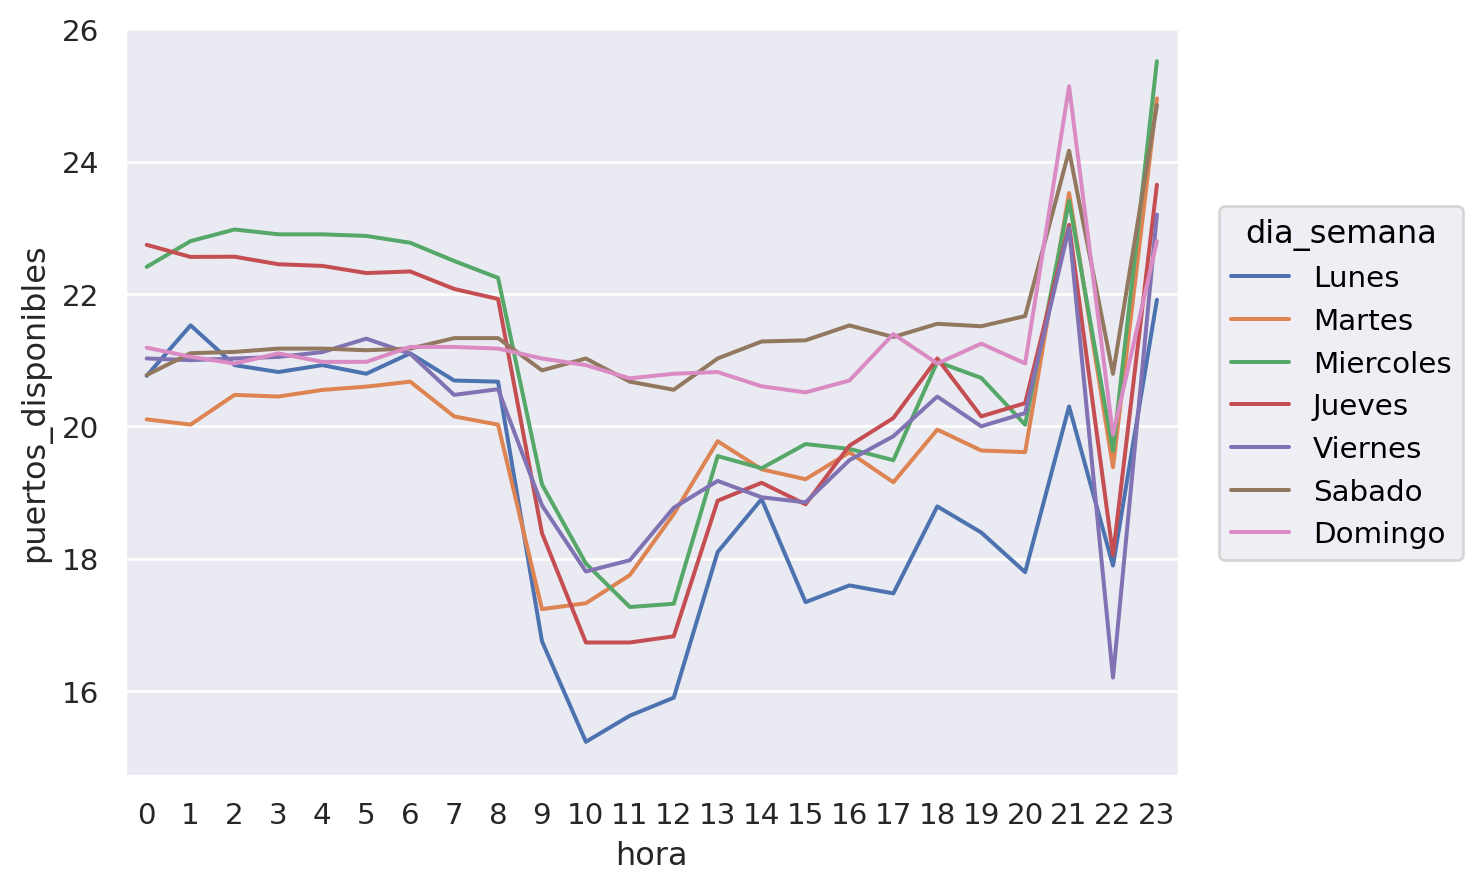

In [ ]:
#Para la disponibilidad de puertos, comprobamos que es inversa a la disponibilidad de bicis:
# las caidas y subidas en la disponibilidad de bicis coincide con la respectiva subida y caida en
# disponibilidad de puertos

(
    so.Plot(data=datos_agrupados, x='hora', y='puertos_disponibles', color='dia_semana')
    .add(so.Line(), so.Agg(func='mean'))
    .scale(x=so.Nominal())
)

/tmp/ipython-input-2548816162.py:2: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  so.Plot(data = datos_agrupados.query('fecha == "2025-05-23"'), x = 'hora', y = 'bicis_disponibles', color='dia_semana')


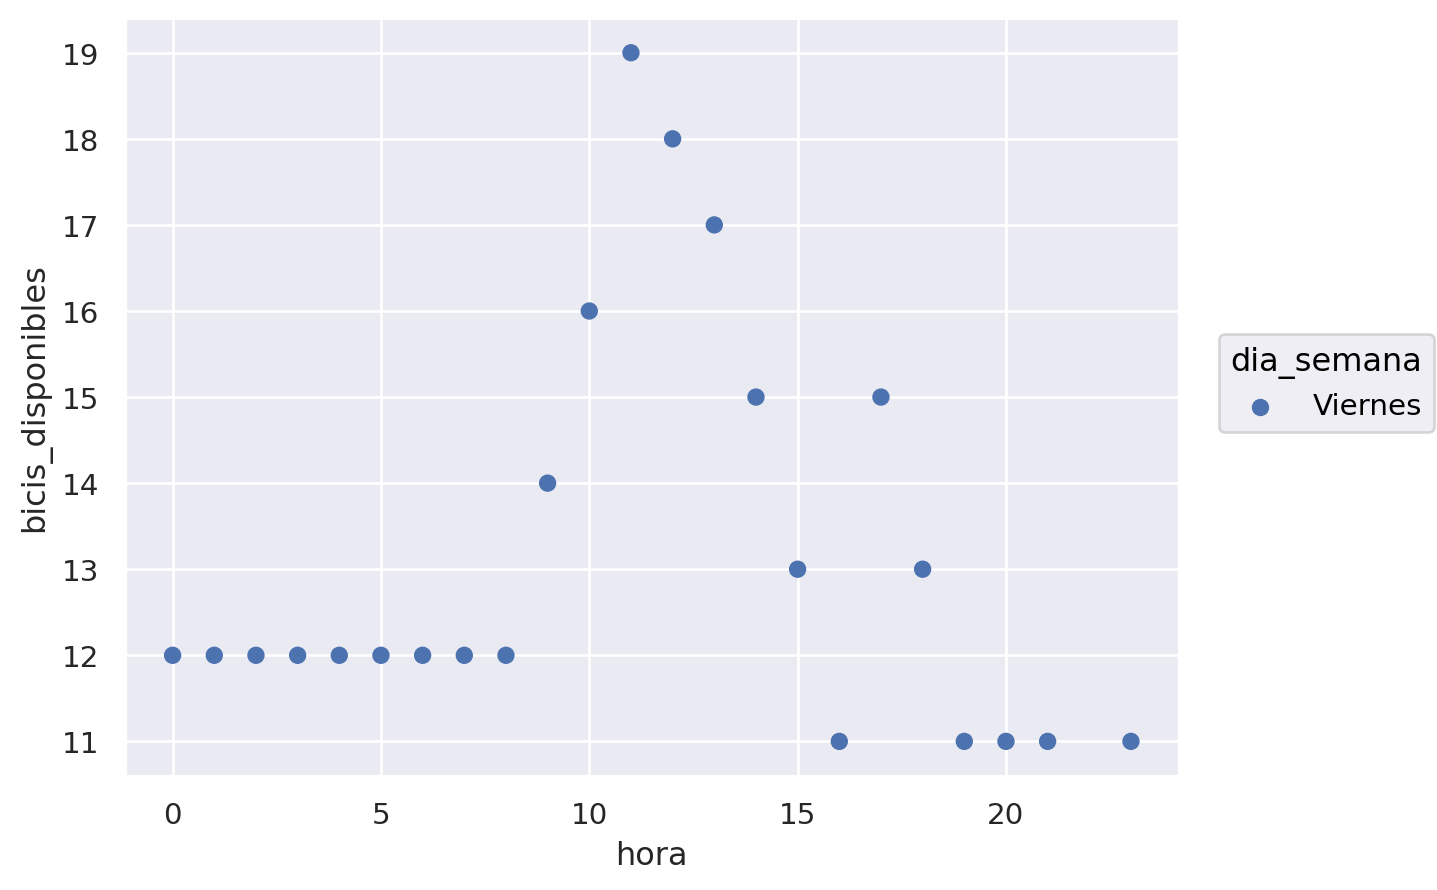

In [ ]:
(
    so.Plot(data = datos_agrupados.query('fecha == "2025-05-23"'), x = 'hora', y = 'bicis_disponibles', color='dia_semana')
    .add(so.Dot())
    )

### Valores anómalos

La fluctuación en la cantidad de bicis disponibles alrededor de las 21:00-22:00 es extraño. En particular el alza en la disponibilidad durante las 22:00 (¿acaso es esperable que muchas bicis sean atracadas a esa hora?). Es posible que esta fluctuación sea un error en la generación de datos.

## Análisis exploratorio

Cantidad de bicis disponibles durante el mantenimiento y horarios en los que se realiza

In [ ]:
 datos.query('status == "MAINTENANCE"')['num_bikes_available'].value_counts()

,count
num_bikes_available,
0,30


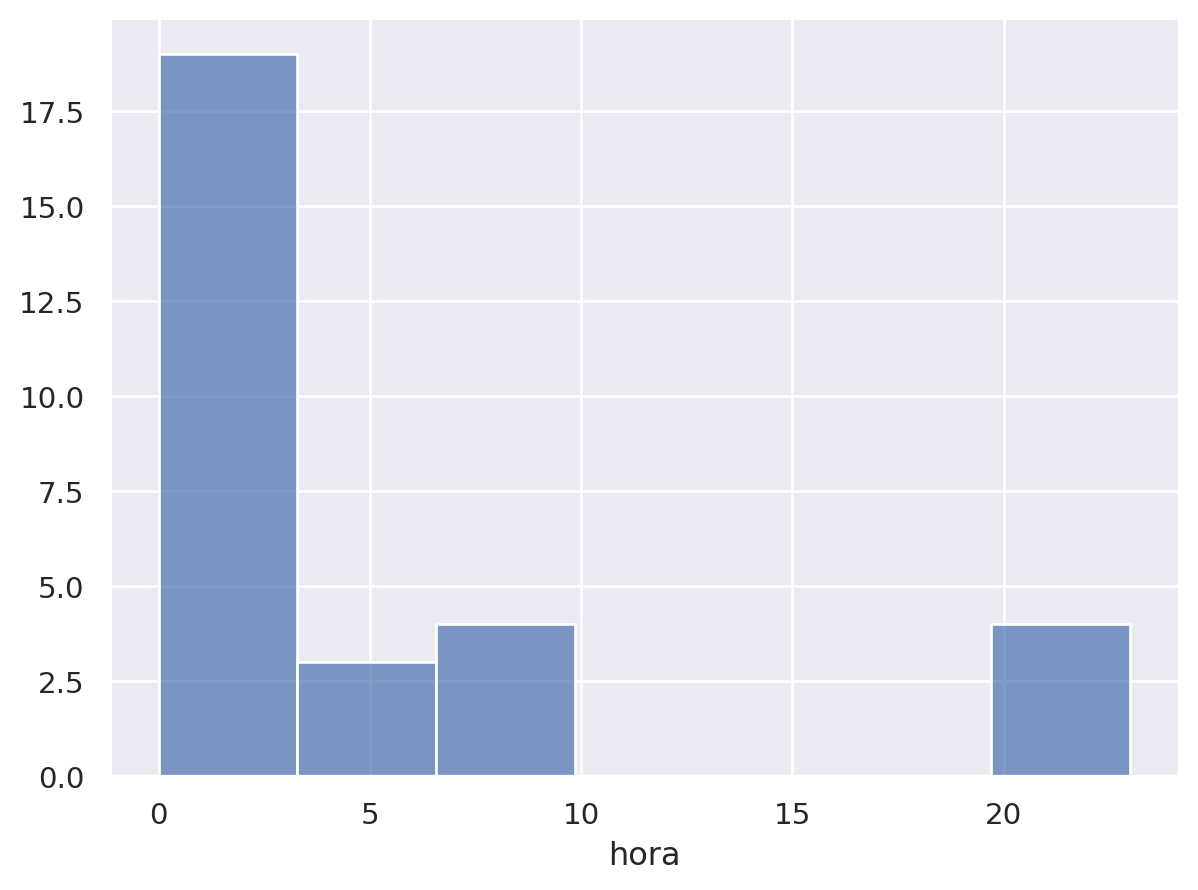

In [ ]:
#Horas en las que se realizan los mantenimientos, tomando com ref base
 (
  so.Plot(data=datos_limpios[datos_limpios['estado'] == 'MAINTENANCE'],x='hora' )
  .add(so.Bars(), so.Hist())
)

Subregistro en ciertas horas y meses

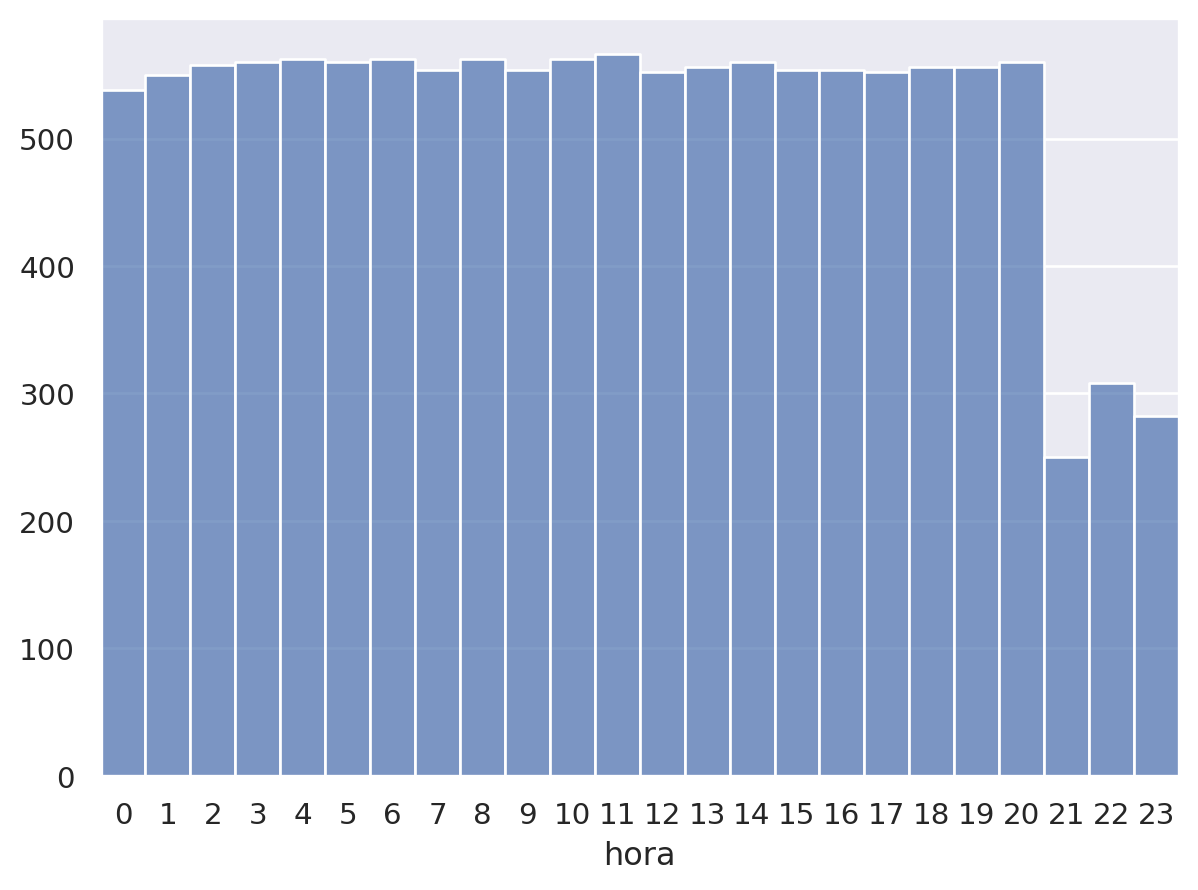

In [ ]:
(
    so.Plot(data = datos_limpios, x='hora')
    .add(so.Bars(), so.Hist())
    .scale(x=so.Nominal())
)

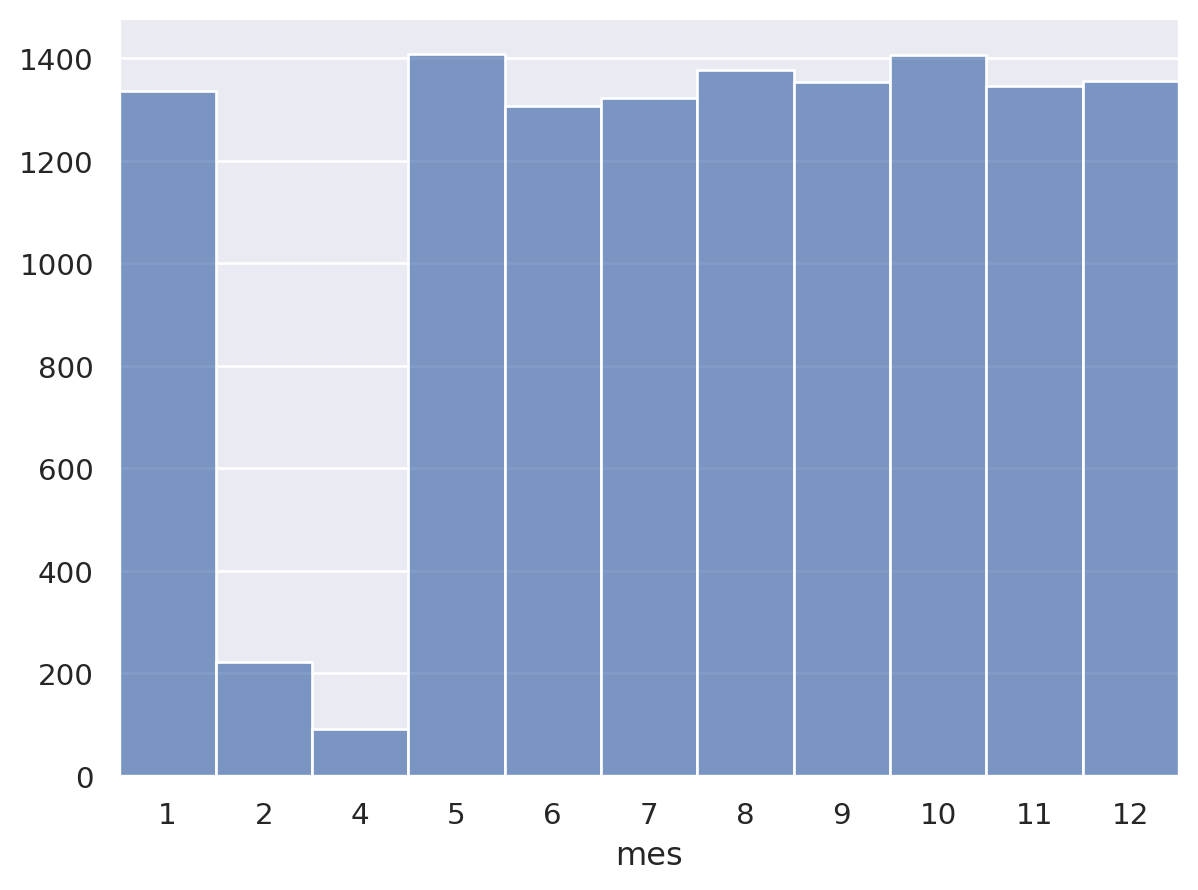

In [ ]:
(
    so.Plot(data = datos_limpios, x='mes')
    .add(so.Bars(), so.Hist())
    .scale(x=so.Nominal())
)

Es notable el subregistro de actividad los meses de Febrero y Abril

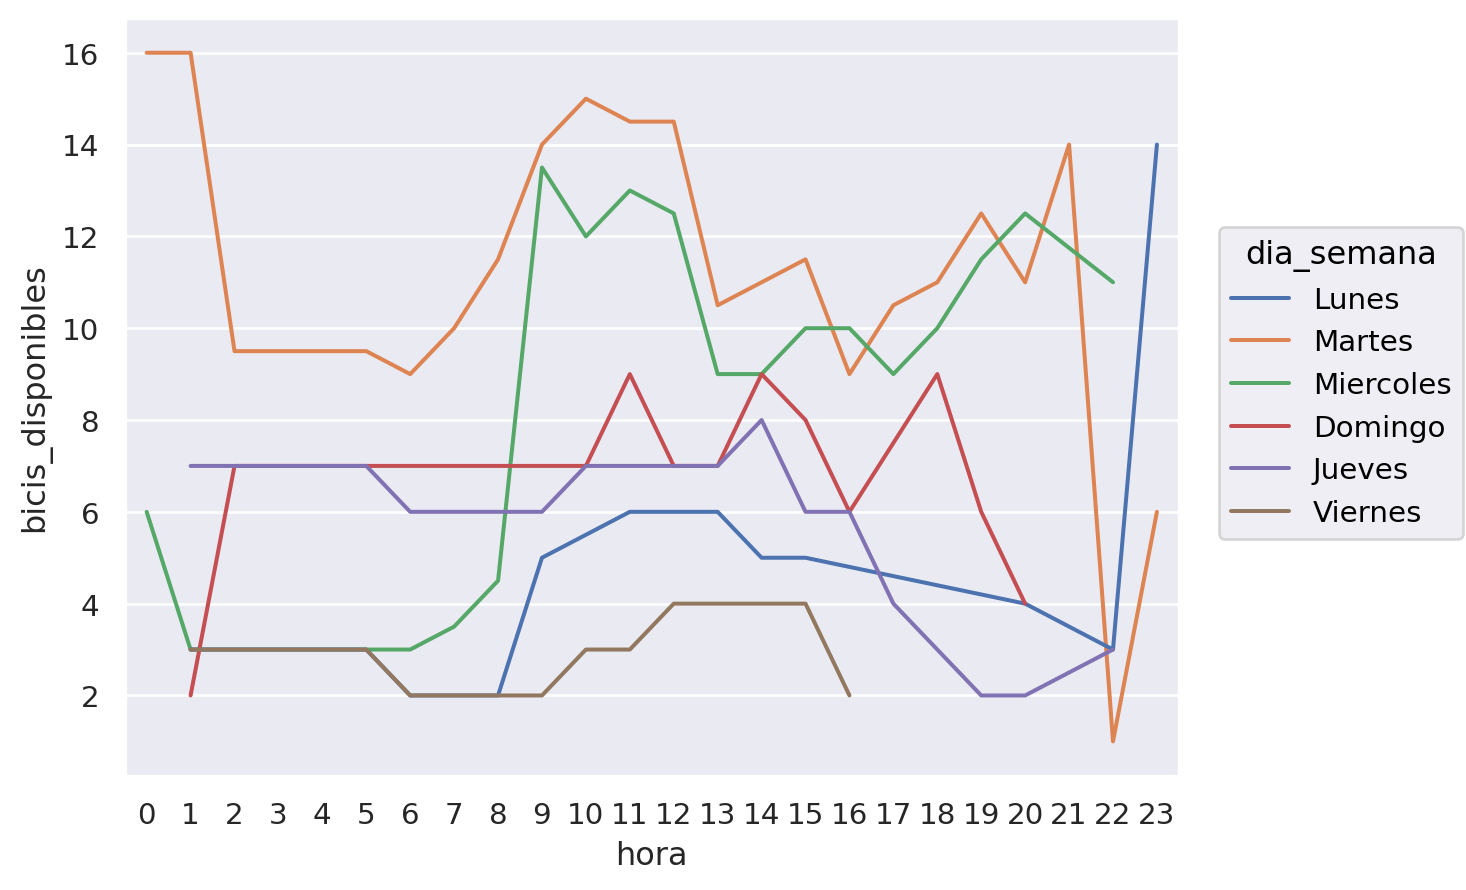

In [ ]:

datos_agrupados_solo_feb_abr = datos_agrupados.query('mes in [2,4] ')

(
    so.Plot(data=datos_agrupados_solo_feb_abr, x='hora', y='bicis_disponibles', color='dia_semana')
    .add(so.Line(), so.Agg(func='mean'))
    .scale(x=so.Nominal())
)

Resaltan dos peculiaridades para estos dos meses: por un lado, no se registran datos para el día sábado; el viernes no tiene datos posteriores a las 16hrs; el domingo no tiene a partir de las 20hrs

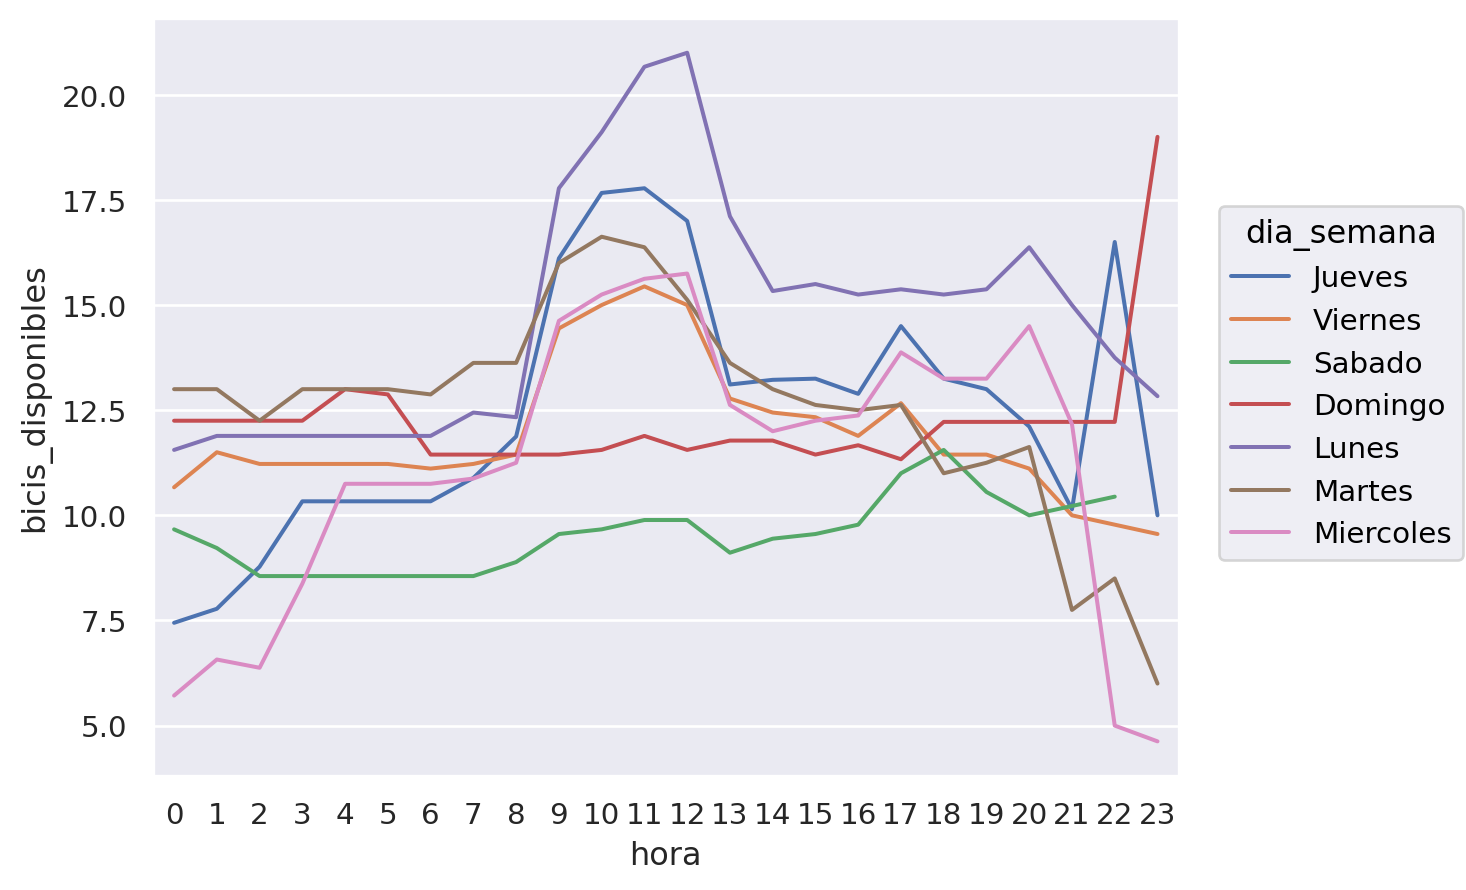

In [ ]:
datos_agrupados_sin_may_jun = datos_agrupados.query('mes in [5,6]')

(
    so.Plot(data=datos_agrupados_sin_may_jun, x='hora', y='bicis_disponibles', color='dia_semana')
    .add(so.Line(), so.Agg(func='mean'))
    .scale(x=so.Nominal())
)

Analisis de uso en finde vs día de semana (aca el codigo...)



*  Aca alguna obs
*   Aca otra



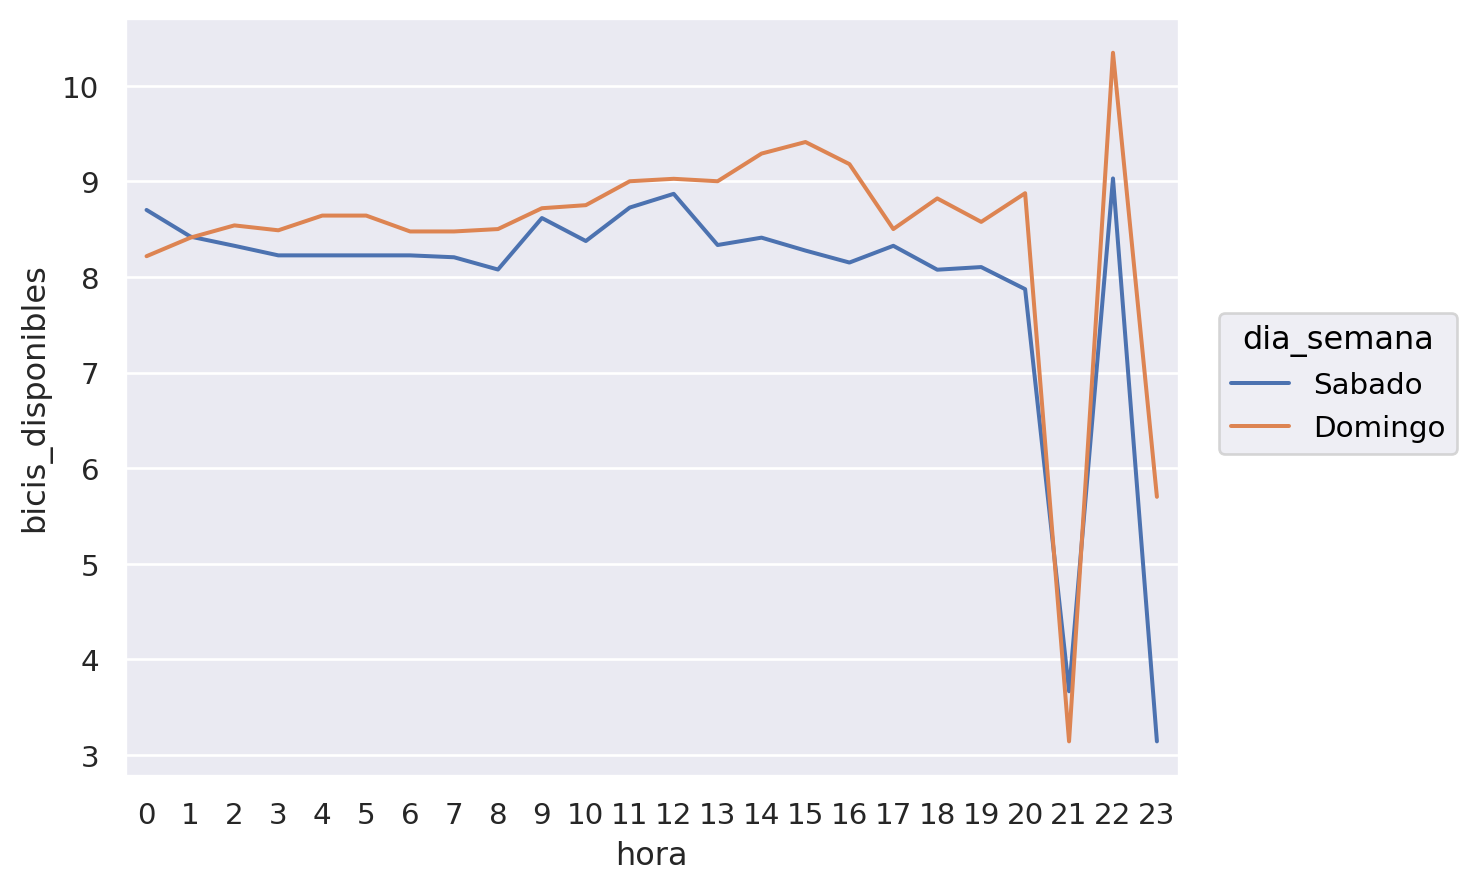

In [ ]:
datos_agrupados_findes =  datos_agrupados.query('dia_semana in ["Sabado", "Domingo"]')
(
    so.Plot(data=datos_agrupados_findes, x='hora', y='bicis_disponibles', color='dia_semana')
    .add(so.Line(), so.Agg(func='mean'))
    .scale(x=so.Nominal())
)

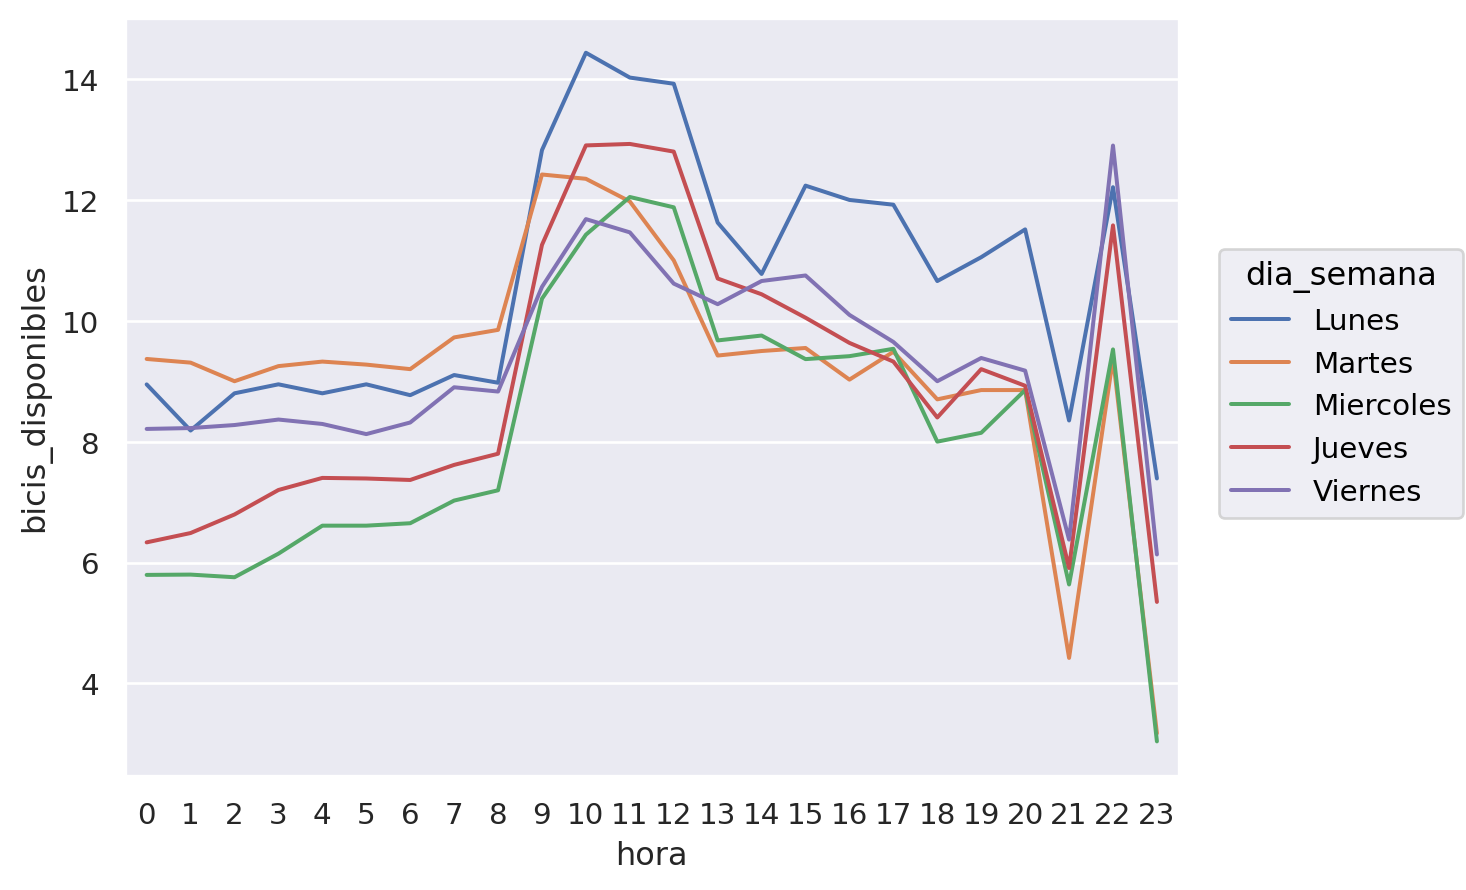

In [ ]:
datos_agrupados_findes =  datos_agrupados.query('dia_semana not in ["Sabado", "Domingo"]')
(
    so.Plot(data=datos_agrupados_findes, x='hora', y='bicis_disponibles', color='dia_semana')
    .add(so.Line(), so.Agg(func='mean'))
    .scale(x=so.Nominal())
)